In [52]:
import numpy as np
import torch
import os
import glob
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.image as mpimg
import matplotlib as mpl

In [2]:
# get codebook
def get_codebook(model_path):
    state_dict = torch.load(model_path)['params']
    quantize_keys = [k for k in state_dict.keys() if 'quantize_group' in k]
    codebooks = []
    for qk in quantize_keys:
        codebooks.append(state_dict[qk].numpy())
    return codebooks

In [3]:
# process codebooks
def proc_codebook(model_path):
    codebooks = get_codebook(model_path)
    labels = []
    for idx in range(len(codebooks)):
        labels.append(np.ones(codebooks[idx].shape[0])*idx)
    data = np.concatenate(codebooks)
    labels = np.concatenate(labels)
    print(np.unique(labels))
    n_samples, n_features = data.shape
    return data, labels, n_samples, n_features

In [76]:
def plot_embedding(data, label, title, savepath=None):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    handles = []
    for i in np.unique(label):
        plt.scatter(data[np.where(label==i),0], data[np.where(label==i),1], marker='o', facecolors='none', s=5, color=plt.cm.Paired((2*i+1)/12), label='codebook Z$_{}$'.format(int(i+1)))
           
    plt.xticks([-0.1, 1.1])
    plt.yticks([0, 1.1])
    plt.legend(loc='upper left', fontsize=8)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', pad_inches=0)
    plt.show()

In [46]:
def main(model_path, savepath, title=None):
    data, label, n_samples, n_features = proc_codebook(model_path)
    tsne = TSNE(n_components=2, init='pca', random_state=233)
    results = tsne.fit_transform(data)
    plot_embedding(results, label, 't-SNE embedding of codebook: {}'.format(title if title is not None else model_path.split('/')[-2]), savepath)

[0.]


/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


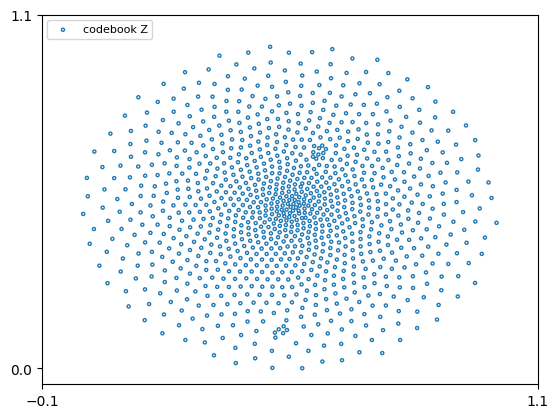

In [77]:
model_path = './experiments/pretrained/FeMaSR_HRP_model_g.pth'
savepath = './codebook_vis/pretrained.png'
main(model_path, savepath, title='VQGAN')

[0. 1. 2. 3. 4.]


/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


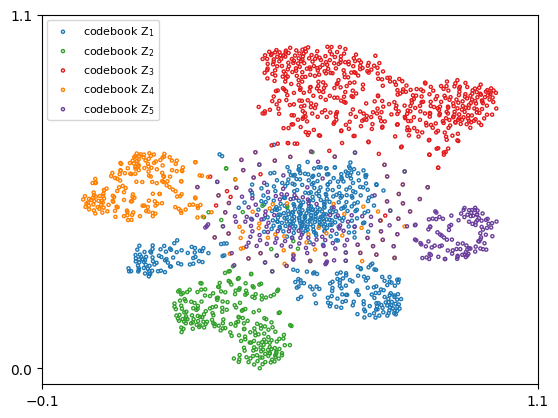

In [75]:
model_path = './experiments/HQ_adacode/net_g_best_.pth'
savepath = './codebook_vis/adacode.png'
main(model_path, savepath, title='AdaCode')

In [8]:
# source = np.random.rand(2)
source = np.array([0.55260064, 0.36427424])

In [9]:
def find_nearest(source, candidates):
    dist = np.sum(np.squeeze((candidates - source)**2), axis=1)
    min_idx = np.argmin(dist)
    return candidates[0, min_idx,:]

In [69]:
def plot_embedding_with_target(data, label, title, savepath=None, plot_voronoi=False):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    
    for i in np.unique(label):
        fig = plt.figure(i)
        ax = plt.subplot(111)
        handles = []
        plt.scatter(data[np.where(label==i),0], data[np.where(label==i),1], marker='o', linewidth=1, s=30, color=plt.cm.Paired(2*i/12), label='codebook{}'.format(int(i)))

        plt.scatter(source[0], source[1], marker='*', c='black', s=100, linewidths=1)
        points = []
        points.append(source)
        target = find_nearest(source, data[np.where(label==i),:])
        if source[0]-0.1 <= target[0] <= source[0]+0.1 and source[1]-0.1 <= target[1] <= source[1]+0.1:
            points.append(target)
            plt.scatter(target[0], target[1], marker='o', s=30, linewidths=3, color=plt.cm.Paired((2*i+1)/12))
            plt.arrow(source[0], source[1], target[0]-source[0], target[1]-source[1], length_includes_head=True, linestyle=':', linewidth=0.01, color=plt.cm.Paired(2*i/12))

        points = np.array(points).squeeze()

        if plot_voronoi:
            vor_range = [source[0]-0.2, source[0]+0.15, source[1]-0.2, source[1]+0.15]
            data2plotvor = data[np.where(label==i)[0], :]
            data2plotvor = data2plotvor[((data2plotvor >= [vor_range[0], vor_range[2]]) & (data2plotvor <= [vor_range[1], vor_range[3]])).all(1)]
            if len(data2plotvor) == 0:
                continue
            vor = Voronoi(data2plotvor)
            voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors=plt.cm.Paired(2*i/12))

        plt.xlim([source[0]-0.08, source[0]+0.08])
        plt.ylim([source[1]-0.08, source[1]+0.08])
        plt.axis('off')
        if savepath:
            plt.savefig(savepath.replace('.png', '_{}.png'.format(i)), bbox_inches='tight', pad_inches=1)
        plt.show()

In [67]:
def main_vq(model_path, savepath, title=None):
    data, label, n_samples, n_features = proc_codebook(model_path)
    tsne = TSNE(n_components=2, init='pca', random_state=233)
    results = tsne.fit_transform(data)
    plot_embedding_with_target(results, label, 'Vector Quantization: {}'.format(title if title is not None else model_path.split('/')[-2]), savepath, plot_voronoi=True)

[0.]


/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


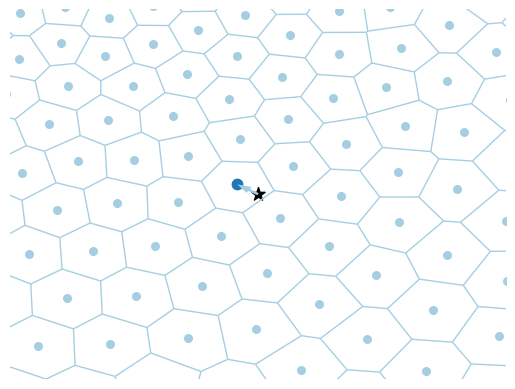

In [70]:
model_path = './experiments/pretrained/FeMaSR_HRP_model_g.pth'
savepath = './codebook_vis/pretrained_vq.png'
main_vq(model_path, savepath, title='VQGAN')

[0. 1. 2. 3. 4.]


/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/femasr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


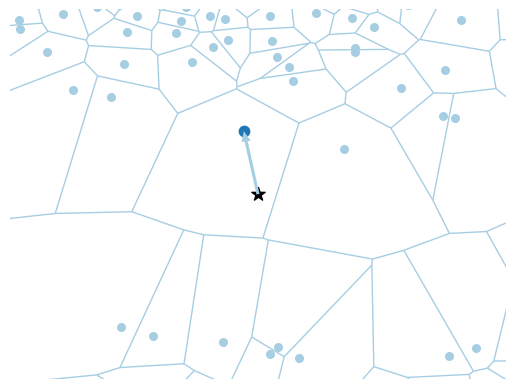

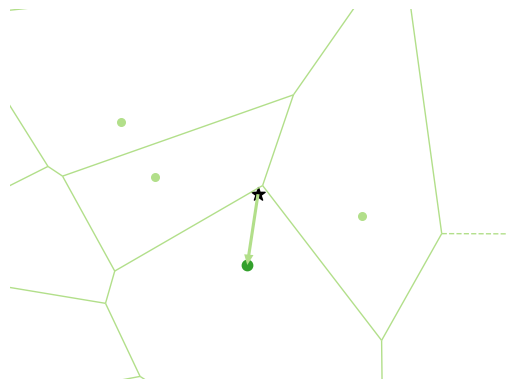

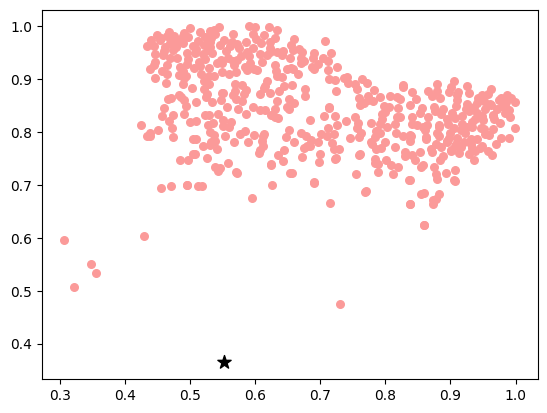

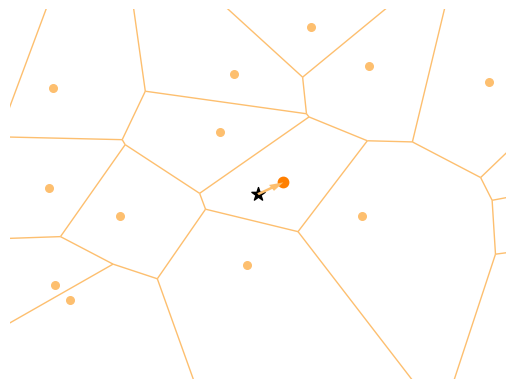

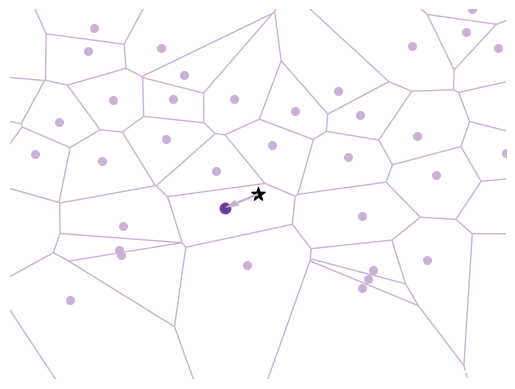

In [71]:
model_path = './experiments/HQ_adacode/net_g_best_.pth'
savepath = './codebook_vis/adacode_vq.png'
main_vq(model_path, savepath, title='AdaCode')